In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import math
import datetime
import tensorflow as tf
import tushare as ts
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [2]:
def split_windows(data,size):
    X=[]
    Y=[]
    for i in range(len(data)-size):
        X.append(data[i:i+size,:])
        Y.append(data[i+size,-1])
    return np.array(X),np.array(Y)

In [4]:
df=pd.read_csv('./test_SZ.csv',usecols=['Open','High','Close','Low','MF','MFR','AMF','AMFR','BClose',
                                        'ma7','ma21','upperband','middleband','lowerband'])
all_data=df.values
train_len=600
train_data=all_data[:train_len,:]
test_data=all_data[train_len:,:]

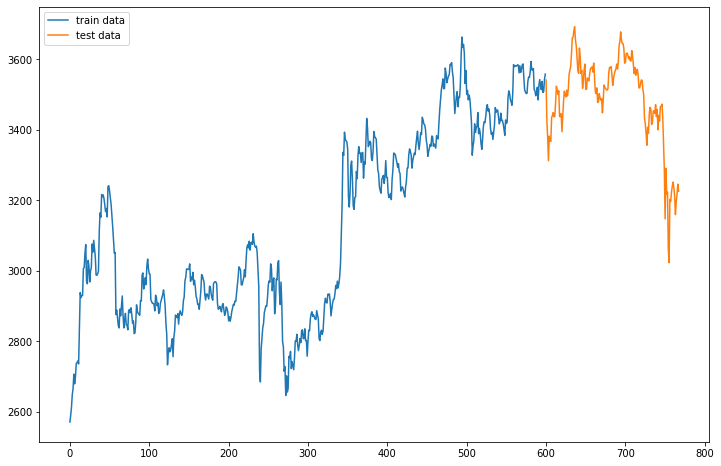

In [5]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(train_data.shape[0]),train_data[:,2],label='train data')
plt.plot(np.arange(train_data.shape[0],train_data.shape[0]+test_data.shape[0]),test_data[:,2],label='test data')
plt.legend()
plt.show()

In [6]:
scaler=MinMaxScaler()
scaled_train_data=scaler.fit_transform(train_data)
scaled_test_data=scaler.transform(test_data)

In [7]:
window_size=10
train_X,train_Y=split_windows(scaled_train_data,size=window_size)
test_X,test_Y=split_windows(scaled_test_data,size=window_size)
print('train shape',train_X.shape,train_Y.shape)
print('test shape',test_X.shape,test_Y.shape)

train shape (590, 10, 14) (590,)
test shape (158, 10, 14) (158,)


In [8]:
window_size=10
fea_num=14
model=keras.models.Sequential([
    keras.layers.Input((window_size,fea_num)),
    keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,padding="same",activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2,strides=1,padding="same"),
    keras.layers.Dropout(0.2),
    keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,padding="same",activation="relu"),
    keras.layers.MaxPooling1D(pool_size=2,strides=1,padding="same"),
    keras.layers.Flatten(), 
    keras.layers.Dense(1)
])
model.compile(loss='mse',optimizer='adam',metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 64)            2752      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [9]:
model.fit(x=train_X,y=train_Y,epochs=50)

Epoch 1/50
19/19 [==============================] - 1s 4ms/step - loss: 0.0509 - mse: 0.0509
Epoch 2/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0144 - mse: 0.0144
Epoch 3/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0106 - mse: 0.0106
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0088 - mse: 0.0088
Epoch 5/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0081 - mse: 0.0081
Epoch 6/50
19/19 [==============================] - ETA: 0s - loss: 0.0063 - mse: 0.006 - 0s 4ms/step - loss: 0.0058 - mse: 0.0058
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0053 - mse: 0.0053
Epoch 8/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0050 - mse: 0.0050
Epoch 9/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0051 - mse: 0.0051
Epoch 10/50
19/19 [==============================] - 0s 3ms/step - loss: 0.0039 - mse: 0.0039
Epoch 11/50
19/19 [============

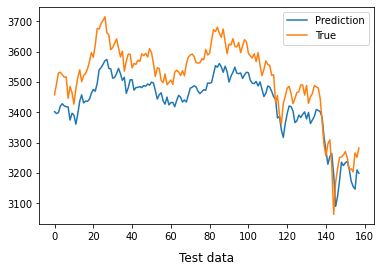

In [10]:
prediction=model.predict(test_X)
scaled_prediction=prediction*(scaler.data_max_[-1]-scaler.data_min_[-1])+scaler.data_min_[-1]
scaled_true=test_Y*(scaler.data_max_[-1]-scaler.data_min_[-1])+scaler.data_min_[-1]
plt.plot(range(len(scaled_prediction)),scaled_prediction,label='Prediction')
plt.plot(range(len(scaled_true)),scaled_true,label='True')
plt.title('Test data',y=-0.2)
plt.legend()
plt.show()

In [22]:
from sklearn import metrics

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

print("MSE",metrics.mean_squared_error(test_Y, prediction))
print("RMSE",np.sqrt(metrics.mean_squared_error(test_Y, prediction)))
print("MAE",metrics.mean_absolute_error(test_Y, prediction))
print("MAPE",mape(test_Y, prediction))

MSE 0.027439175661253347
RMSE 0.16564774571739074
MAE 0.16198920550970555
MAPE 15.642517602820055


In [23]:
def create_UD(data):
    UD=[]
    for i in range(len(data)-1):
        if(data[i]>data[i+1]):
            UD.append(0)
        else:
            UD.append(1)
    return np.array(UD)

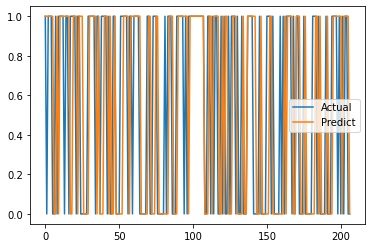

In [24]:
test_UD=create_UD(test_Y)
predict_UD=create_UD(prediction)

In [25]:
def rate_acc(true,predict):
    equal=0
    for i in range(len(true)):
        if(true[i]==predict[i]):
            equal=equal+1
    acc=equal/len(true)
    return acc

In [26]:
test_acc=rate_acc(test_UD,predict_UD)
print(test_acc)

0.5845410628019324
